In [78]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [79]:
df = pd.read_csv('Frozen_Dessert_Production.csv',parse_dates=True,index_col='DATE')

In [80]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [81]:
df.columns=['Productions']

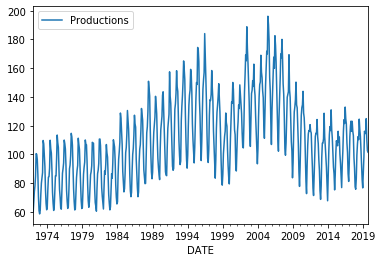

In [82]:
df.plot()

In [83]:
len(df)

573

In [84]:
test_size=len(df)-18

In [85]:
train_set = df.iloc[:test_size]
test_set=df.iloc[test_size:]

In [86]:
len(test_set)

18

In [87]:
from sklearn.preprocessing import MinMaxScaler 

In [88]:
scaler=MinMaxScaler()

In [89]:
scaler.fit(train_set)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [90]:
scaled_train=scaler.transform(train_set)
scaled_test=scaler.transform(test_set)

In [91]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [92]:
length=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [93]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,LSTM,GRU 

In [94]:
model = Sequential()

model.add(LSTM(148,activation='tanh',input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [95]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 148)               88800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 149       
Total params: 88,949
Trainable params: 88,949
Non-trainable params: 0
_________________________________________________________________


In [96]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

In [98]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [99]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

C:\Users\admin\anaconda3\envs\mytfenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
543/543 [==============================] - 7s 8ms/step - loss: 0.0195 - val_loss: 0.0052
Epoch 2/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 3/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 4/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 5/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 6/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0035 - val_loss: 0.0027
Epoch 7/20
543/543 [==============================] - 4s 7ms/step - loss: 0.0032 - val_loss: 0.0022


In [100]:
losses = pd.DataFrame(model.history.history)

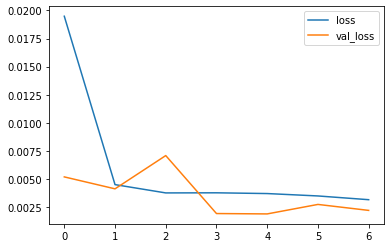

In [101]:
losses.plot()

In [102]:
test_prediction =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test_set)):
    current_pred=model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch= np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [103]:
true_predictions=scaler.inverse_transform(test_prediction)

In [104]:
test_set['Predictions'] =true_predictions

C:\Users\admin\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [105]:
test_set

,Productions,Predictions
DATE,,
2018-04-01,112.4309,114.976107
2018-05-01,110.3544,119.654978
2018-06-01,124.5841,121.116347
2018-07-01,117.2215,117.878927
2018-08-01,112.6779,110.101131
2018-09-01,103.3118,98.887344
2018-10-01,92.1321,88.341210
2018-11-01,82.4347,82.247929
2018-12-01,76.7608,83.300640


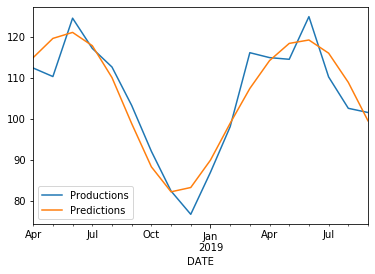

In [106]:
test_set.plot()

In [107]:
from sklearn.metrics import mean_squared_error 

In [108]:
np.sqrt(mean_squared_error(test_set['Productions'],test_set['Predictions']))

4.714704407166392